In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = tf.keras.datasets.fashion_mnist.load_data()
(digit_x_train, digit_y_train), (digit_x_test, digit_y_test) = tf.keras.datasets.mnist.load_data()

fashion_x_train = fashion_x_train.reshape((-1, 28, 28, 1))/255
fashion_x_test = fashion_x_test.reshape((-1, 28, 28, 1))/255
digit_x_train = digit_x_train.reshape((-1, 28, 28, 1))/255
digit_x_test = digit_x_test.reshape((-1, 28, 28, 1))/255

fashion_y_train = fashion_y_train.reshape(-1, 1)
fashion_y_test = fashion_y_test.reshape(-1, 1)
digit_y_train = digit_y_train.reshape(-1, 1)
digit_y_test = digit_y_test.reshape(-1, 1)

fashion_x_train_output = fashion_x_train.reshape((fashion_x_train.shape[0], -1))
fashion_x_test_output = fashion_x_test.reshape((fashion_x_test.shape[0], -1))
digit_x_train_output = digit_x_train.reshape((digit_x_train.shape[0], -1))
digit_x_test_output = digit_x_test.reshape((digit_x_test.shape[0], -1))

In [3]:
input_layer = tf.keras.layers.Input(fashion_x_train.shape[1:])
main_x = tf.keras.layers.Conv2D(16, 3, padding = 'same')(input_layer)
main_x = tf.keras.layers.Conv2D(16, 3, padding = 'same')(main_x)
main_x = tf.keras.layers.MaxPool2D(strides = 1, padding = 'valid')(main_x)

ood_x = tf.keras.layers.Flatten()(main_x)
ood_x = tf.keras.layers.Dense(100, activation = 'relu')(ood_x)

main_x = tf.keras.layers.Conv2D(32, 3, padding = 'same')(main_x)
main_x = tf.keras.layers.Conv2D(32, 3, padding = 'same')(main_x)
main_x = tf.keras.layers.MaxPool2D(strides = 1, padding = 'valid')(main_x)

branch_x = tf.keras.layers.Flatten()(main_x)
ood_x = tf.keras.layers.Concatenate()([ood_x, branch_x])
ood_x = tf.keras.layers.Dense(100, activation = 'relu')(ood_x)

main_x = tf.keras.layers.Flatten()(main_x)
main_x = tf.keras.layers.Dense(100, activation = 'relu')(main_x)
main_output = tf.keras.layers.Dense(10, activation = 'softmax')(main_x)

ood_x = tf.keras.layers.Concatenate()([ood_x, main_x])
ood_output = tf.keras.layers.Dense(28 * 28, activation = 'sigmoid')(ood_x)

model = tf.keras.models.Model(input_layer, [main_output, ood_output])
model.compile(
    loss = ['sparse_categorical_crossentropy', 'cosine_similarity'],
    optimizer = 'adam'
)

2021-10-29 10:56:06.256819: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-29 10:56:06.256930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 27, 27, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [5]:
callback = tf.keras.callbacks.EarlyStopping(min_delta = 0.03, patience = 3, restore_best_weights = True)
model.fit(
    digit_x_train,
    [digit_y_train, digit_x_train_output],
    epochs = 100,
    batch_size = 512,
    validation_split = 0.2,
    callbacks = [callback]
)

2021-10-29 10:56:07.031430: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-29 10:56:07.031684: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2021-10-29 10:56:07.281940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - ETA: 0s - loss: -0.5132 - dense_3_loss: 0.2436 - dense_4_loss: -0.7568

2021-10-29 10:56:20.473678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 14s 113ms/step - loss: -0.5132 - dense_3_loss: 0.2436 - dense_4_loss: -0.7568 - val_loss: -0.8234 - val_dense_3_loss: 0.0772 - val_dense_4_loss: -0.9006
Epoch 2/100
94/94 [==============================] - 10s 109ms/step - loss: -0.8838 - dense_3_loss: 0.0538 - dense_4_loss: -0.9376 - val_loss: -0.8993 - val_dense_3_loss: 0.0553 - val_dense_4_loss: -0.9547
Epoch 3/100
94/94 [==============================] - 10s 109ms/step - loss: -0.9261 - dense_3_loss: 0.0348 - dense_4_loss: -0.9610 - val_loss: -0.9139 - val_dense_3_loss: 0.0514 - val_dense_4_loss: -0.9652
Epoch 4/100
94/94 [==============================] - 10s 109ms/step - loss: -0.9456 - dense_3_loss: 0.0226 - dense_4_loss: -0.9682 - val_loss: -0.9165 - val_dense_3_loss: 0.0528 - val_dense_4_loss: -0.9693
Epoch 5/100
94/94 [==============================] - 10s 109ms/step - loss: -0.9526 - dense_3_loss: 0.0192 - dense_4_loss: -0.9718 - val_loss: -0.9220 - val_dense_3_loss: 0.0506 - val_dens

In [16]:
preds, autoencode = model.predict(digit_x_test)
test_similarities = tf.keras.losses.cosine_similarity(digit_x_test_output.astype('float32'), autoencode.astype('float32'))
in_domain_similarities = test_similarities.numpy()
preds = preds.argmax(axis = 1)

In [17]:
threshold = in_domain_similarities.mean() + 1.5*in_domain_similarities.std()

In [18]:
print(classification_report(digit_y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.97      0.99      0.98      1028
           8       0.99      0.97      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



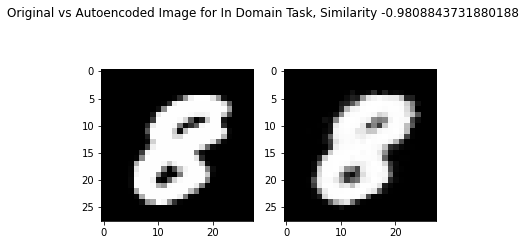

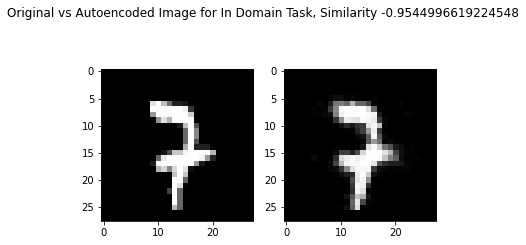

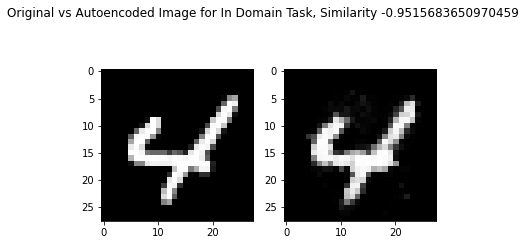

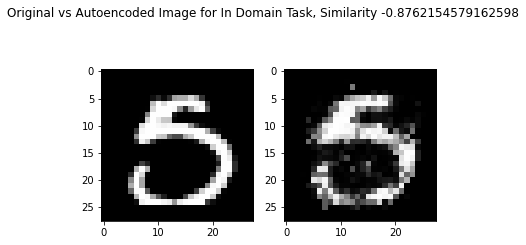

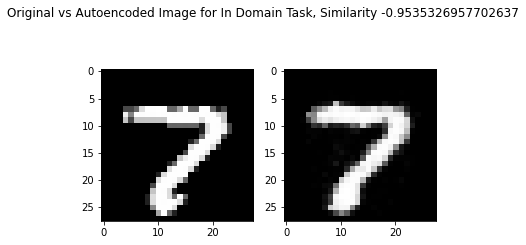

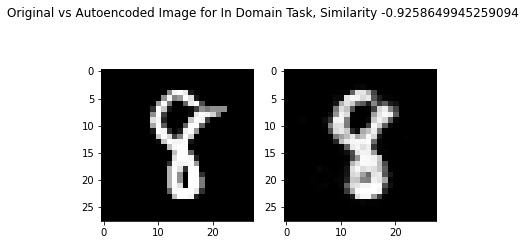

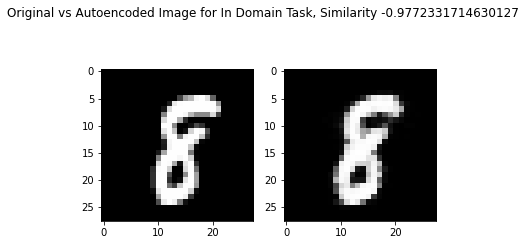

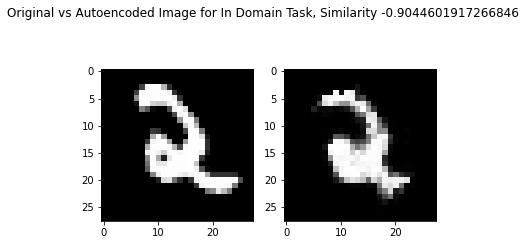

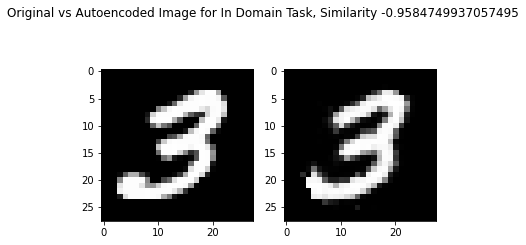

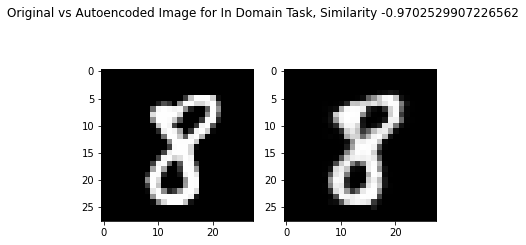

In [20]:
for random_index in np.random.choice(np.arange(preds.shape[0]), 10, replace = False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.suptitle(f'Original vs Autoencoded Image for In Domain Task, Similarity {in_domain_similarities[random_index]}')
    ax1.imshow(digit_x_test[random_index], cmap = 'Greys_r')
    ax2.imshow(autoencode[random_index].reshape((28, 28, 1)), cmap = 'Greys_r')
    plt.show()

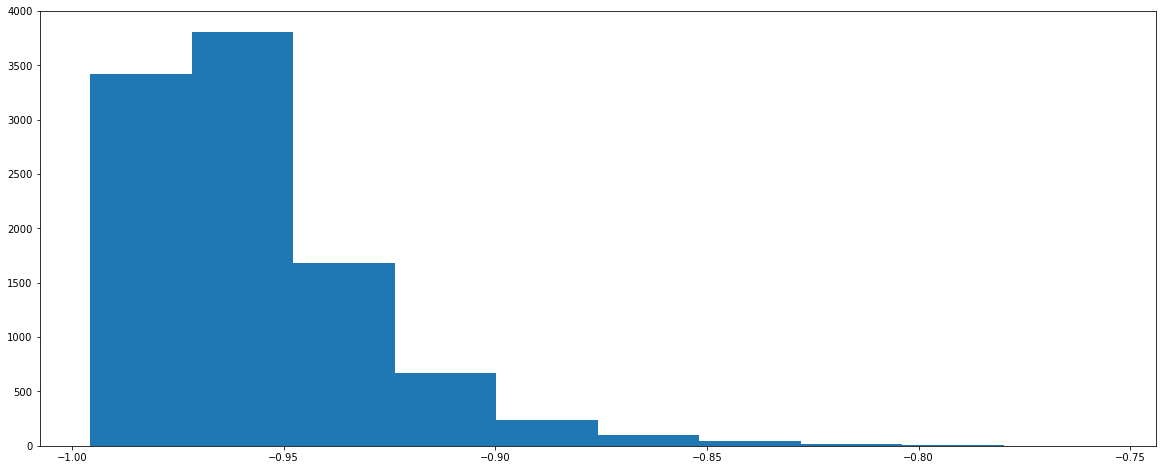

In [21]:
plt.figure(figsize = (20, 8))
plt.hist(in_domain_similarities)
plt.show()

In [23]:
preds, autoencode = model.predict(fashion_x_test)
test_similarities = tf.keras.losses.cosine_similarity(fashion_x_test_output.astype('float32'), autoencode)
ood_similarities = test_similarities.numpy()
preds = preds.argmax(axis = 1)

In [24]:
print(classification_report(fashion_y_test, preds))

              precision    recall  f1-score   support

           0       0.02      0.01      0.01      1000
           1       0.15      0.45      0.23      1000
           2       0.00      0.01      0.00      1000
           3       0.12      0.04      0.05      1000
           4       0.01      0.01      0.01      1000
           5       0.52      0.31      0.39      1000
           6       0.14      0.21      0.16      1000
           7       0.00      0.00      0.00      1000
           8       0.07      0.01      0.02      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.09     10000
weighted avg       0.10      0.10      0.09     10000



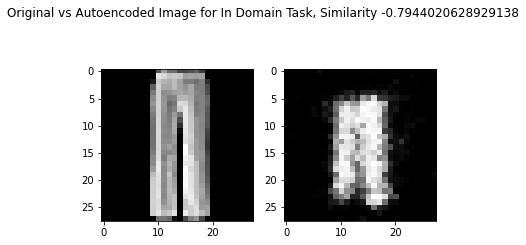

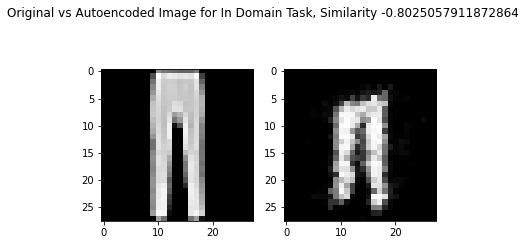

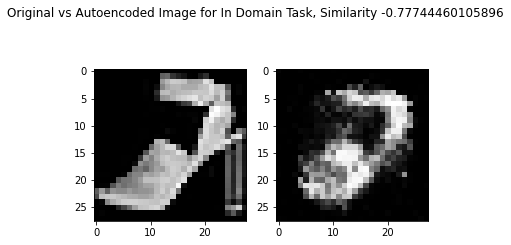

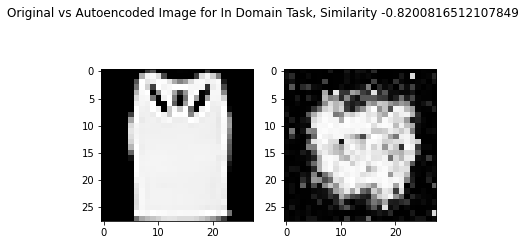

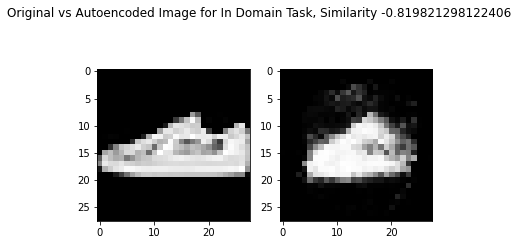

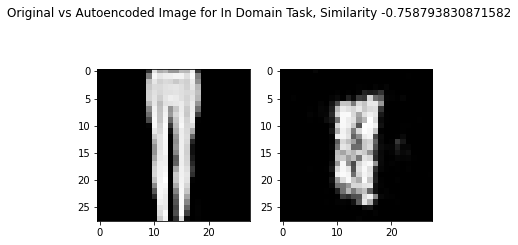

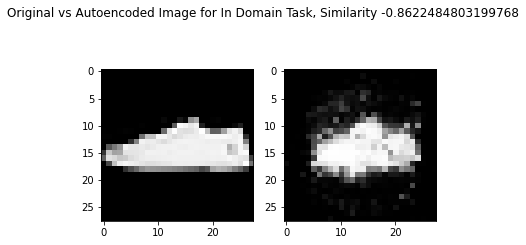

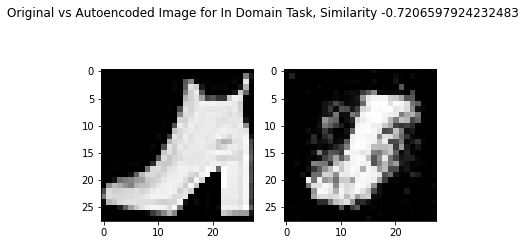

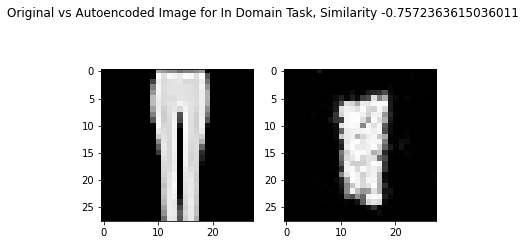

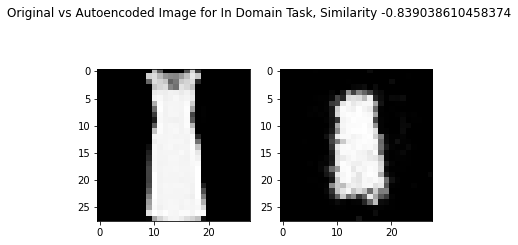

In [25]:
for random_index in np.random.choice(np.arange(preds.shape[0]), 10, replace = False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.suptitle(f'Original vs Autoencoded Image for In Domain Task, Similarity {ood_similarities[random_index]}')
    ax1.imshow(fashion_x_test[random_index], cmap = 'Greys_r')
    ax2.imshow(autoencode[random_index].reshape((28, 28, 1)), cmap = 'Greys_r')
    plt.show()

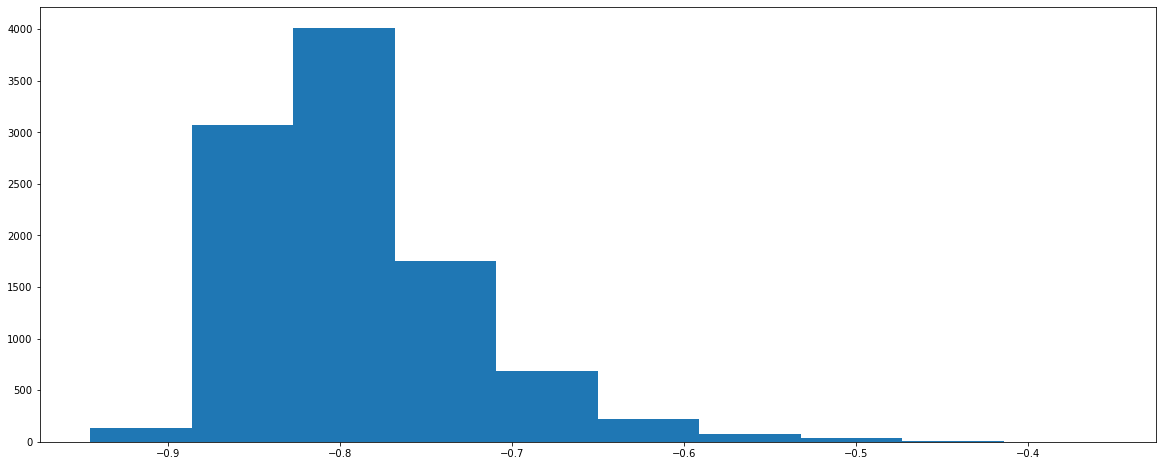

In [26]:
plt.figure(figsize = (20, 8))
plt.hist(ood_similarities)
plt.show()

In [27]:
ood_trust = ood_similarities <= threshold
pd.Series(ood_trust).value_counts()

False    9980
True       20
dtype: int64